## 1. Importing Necessary Libraries ##

In [ ]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation , Embedding, GlobalMaxPooling1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10331830591893462776
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10655502635738643535
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16115234849522463230
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15859989081319105797
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## 2. Reading and Visualization of the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
main_directory = '/content/drive/My Drive/My Works/Bangla YouTube/Emotion.csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

nltk_stop_words = '/content/drive/My Drive/Thesis/Thesis Codes 4_2/Dataset/stopwords.bangla.dat'

In [ ]:
dataset = pd.read_csv(main_directory,encoding = 'utf-8',sep=';')
dataset.head()

,id,text,emotion,lan,domain
0,2275,Hands down. You are good. I mean smart good.,joy,EN,funny_video
1,2283,Your are very good. keep it up,none,EN,funny_video
2,2292,Man!! I will never get used to these videos of...,surprise,EN,funny_video
3,2293,ডিসলাইক দেয়া 32,none,BN,funny_video
4,2298,ব্যাপক বিনোদন।,joy,BN,funny_video


In [ ]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,id,text,emotion,lan,domain
0,18728,ওরে পাপন তোরে গুলি করে মারা দরকার কারণ আশরাফুল...,anger,BN,sports_video
1,27660,Onek onek dhonnobad Bhai\n,joy,RN,review_video
2,7774,"not better phone,just logo showing,need more d...",disgust,EN,review_video
3,25311,এই খানকি আর খানকির পোলারদের সাথে কথা বলতে গেলে...,anger,BN,talkshow_video
4,27967,এমন আরো কতো চুলকানি যে সুনতে হবে আল্লাহ জানেন।\n,disgust,BN,news_video


In [ ]:
# Get indexes where lan column has value EN and RN
indexNames = dataset[(dataset['lan'] == 'EN') | (dataset['lan'] == 'RN')].index

# Delete these row indexes from dataFrame
dataset = dataset.drop(indexNames)

In [ ]:
dataset.head()

,id,text,emotion,lan,domain
0,18728,ওরে পাপন তোরে গুলি করে মারা দরকার কারণ আশরাফুল...,anger,BN,sports_video
3,25311,এই খানকি আর খানকির পোলারদের সাথে কথা বলতে গেলে...,anger,BN,talkshow_video
4,27967,এমন আরো কতো চুলকানি যে সুনতে হবে আল্লাহ জানেন।\n,disgust,BN,news_video
7,4156,ইংলিশে অর্নাস মাষ্টার্স করা লোকের আবার চাকরির ...,disgust,BN,drama_video
9,25170,মুফতি সাহেব দেখি গায়ের জোরে মিথ্যা বলেই যাচ্ছে...,disgust,BN,talkshow_video


In [ ]:
emotion = np.array(dataset['emotion'])

In [ ]:
class_values = dataset['emotion'].unique()
print(class_values)

['anger' 'disgust' 'surprise' 'joy' 'sad' 'none' 'others' 'fear']


In [ ]:
dataset.groupby('emotion')['text'].count()

emotion
anger       202
disgust     305
fear          1
joy         190
none        209
others        1
sad          42
surprise     56
Name: text, dtype: int64

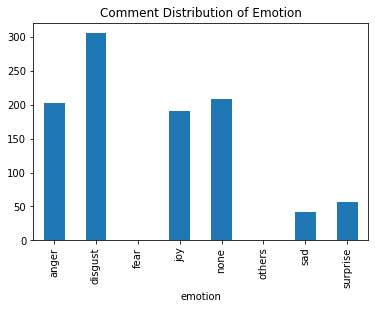

In [ ]:
dataset.groupby('emotion')['text'].count().plot(kind='bar' , title= 'Comment Distribution of Emotion')

In [ ]:
dataset['text']
dataset.head()

,id,text,emotion,lan,domain
0,18728,ওরে পাপন তোরে গুলি করে মারা দরকার কারণ আশরাফুল...,anger,BN,sports_video
3,25311,এই খানকি আর খানকির পোলারদের সাথে কথা বলতে গেলে...,anger,BN,talkshow_video
4,27967,এমন আরো কতো চুলকানি যে সুনতে হবে আল্লাহ জানেন।\n,disgust,BN,news_video
7,4156,ইংলিশে অর্নাস মাষ্টার্স করা লোকের আবার চাকরির ...,disgust,BN,drama_video
9,25170,মুফতি সাহেব দেখি গায়ের জোরে মিথ্যা বলেই যাচ্ছে...,disgust,BN,talkshow_video


In [ ]:
def plot_model(history):
    # Plot training & validation accuracy values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy',linewidth=3.0)
    plt.plot(x, val_acc, 'r', label='Validation accuracy',linewidth=3.0)
    plt.title('Training and validation accuracy',fontsize=18)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss',linewidth=3.0)
    plt.plot(x, val_loss, 'r', label='Validation loss',linewidth=3.0)
    plt.title('Training and validation loss', fontsize=18)
    plt.legend()


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


## 3. Label Encoding & Vectorization


In [ ]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(emotion)

print(label_encoder.classes_)

label_OneHotEncoder = OneHotEncoder()
encoded_label = label_OneHotEncoder.fit_transform(encoded_label.reshape(-1,1)).toarray()

['anger' 'disgust' 'fear' 'joy' 'none' 'others' 'sad' 'surprise']


In [ ]:
vocabulary_size = 10000
input_length = 30

In [ ]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])
data = pad_sequences(sequences, maxlen = input_length)

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(data, encoded_label, test_size = 0.2)

In [ ]:
num_classes = len(class_values)
validation_split = 0.1

# 4. Model Creation & Training

# LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000


validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,activation='relu'))
model_lstm.add(Dense(num_classes, activation='softmax'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 1000)          10000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               440400    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 808       
Total params: 10,441,208
Trainable params: 10,441,208
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_lstm.fit(train_data, train_label, validation_split = validation_split, epochs=100, batch_size=4,
                    shuffle = True, callbacks = callback)

Epoch 1/100
161/161 [==============================] - 46s 283ms/step - loss: 0.0371 - accuracy: 0.9067 - f1_m: 0.9009 - precision_m: 0.9332 - recall_m: 0.8784 - val_loss: 0.4519 - val_accuracy: 0.5155 - val_f1_m: 0.4198 - val_precision_m: 0.5711 - val_recall_m: 0.3476
Epoch 2/100
161/161 [==============================] - 45s 282ms/step - loss: 0.0665 - accuracy: 0.9005 - f1_m: 0.8946 - precision_m: 0.9229 - recall_m: 0.8742 - val_loss: 0.4349 - val_accuracy: 0.4596 - val_f1_m: 0.3582 - val_precision_m: 0.4593 - val_recall_m: 0.3049
Epoch 3/100
161/161 [==============================] - 46s 283ms/step - loss: 0.0364 - accuracy: 0.9082 - f1_m: 0.9039 - precision_m: 0.9270 - recall_m: 0.8877 - val_loss: 0.4741 - val_accuracy: 0.4845 - val_f1_m: 0.3992 - val_precision_m: 0.5386 - val_recall_m: 0.3415
Epoch 4/100
161/161 [==============================] - 45s 282ms/step - loss: 0.0386 - accuracy: 0.8989 - f1_m: 0.8991 - precision_m: 0.9218 - recall_m: 0.8830 - val_loss: 0.4733 - val_accur

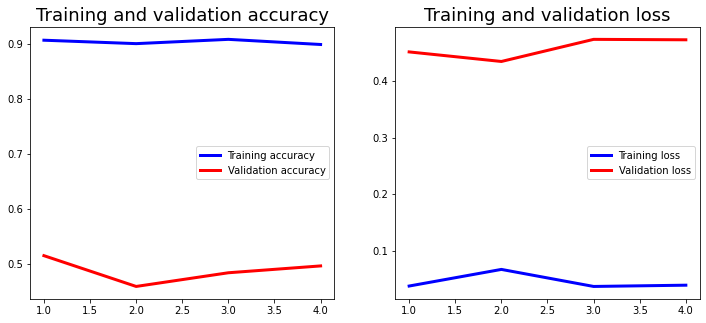

In [ ]:
plot_model(history)

In [ ]:
model_lstm.evaluate(test_data, test_label, verbose = 1)

7/7 [==============================] - 0s 30ms/step - loss: 0.5140 - accuracy: 0.3663 - f1_m: 0.2875 - precision_m: 0.3949 - recall_m: 0.2286


[0.5140079259872437,
 0.3663366436958313,
 0.2874614894390106,
 0.3948991894721985,
 0.22857142984867096]

In [ ]:
model_lstm.save('/content/drive/My Drive/My Works/Bangla YouTube/model_lstm_bangla.h5')

# Stacked LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 128
l2_lstm_units = 64

validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model = Sequential()

model.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model.add(Dense(dense_input, activation='tanh'))

model.add(LSTM(l1_lstm_units, dropout = l1_dropout, recurrent_dropout = l1_recurrent_dropout, 
                             return_sequences = True, activation='tanh'))
model.add(LSTM(l2_lstm_units, dropout = l2_dropout, recurrent_dropout = l2_recurrent_dropout, 
                             return_sequences = False, activation='tanh'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 1000)          10000000  
_________________________________________________________________
dense_4 (Dense)              (None, 30, 1000)          1001000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           578048    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 11,628,976
Trainable params: 11,628,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, batch_size=4,
                    shuffle = True, callbacks = callback)



Epoch 1/100
161/161 [==============================] - 74s 461ms/step - loss: 0.3169 - accuracy: 0.2830 - f1_m: 0.0331 - precision_m: 0.0631 - recall_m: 0.0243 - val_loss: 0.2899 - val_accuracy: 0.3789 - val_f1_m: 0.1062 - val_precision_m: 0.2154 - val_recall_m: 0.0732
Epoch 2/100
161/161 [==============================] - 73s 456ms/step - loss: 0.2368 - accuracy: 0.5428 - f1_m: 0.4016 - precision_m: 0.5776 - recall_m: 0.3349 - val_loss: 0.2711 - val_accuracy: 0.4845 - val_f1_m: 0.3447 - val_precision_m: 0.5508 - val_recall_m: 0.2744
Epoch 3/100
161/161 [==============================] - 73s 454ms/step - loss: 0.1512 - accuracy: 0.7698 - f1_m: 0.7571 - precision_m: 0.8333 - recall_m: 0.7101 - val_loss: 0.3014 - val_accuracy: 0.5031 - val_f1_m: 0.4357 - val_precision_m: 0.5386 - val_recall_m: 0.3780
Epoch 4/100
161/161 [==============================] - 73s 455ms/step - loss: 0.1031 - accuracy: 0.8414 - f1_m: 0.8398 - precision_m: 0.8903 - recall_m: 0.8028 - val_loss: 0.3352 - val_accur

In [ ]:
model.evaluate(test_data, test_label, verbose = 1)

7/7 [==============================] - 0s 45ms/step - loss: 0.3939 - accuracy: 0.4059 - f1_m: 0.3980 - precision_m: 0.4408 - recall_m: 0.3643


[0.39390328526496887,
 0.40594059228897095,
 0.3979780972003937,
 0.44081005454063416,
 0.3642857074737549]

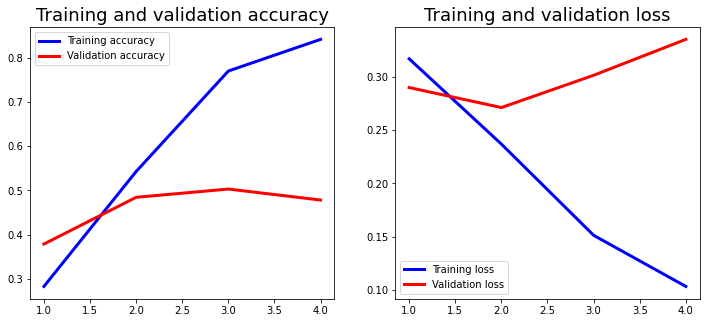

In [ ]:
plot_model(history)

In [ ]:
model.save('/content/drive/My Drive/My Works/Bangla YouTube/model_stacked_lstm_bangla.h5')

#Stacked LSTM with CNN using pre-trained word embeddings

In [ ]:
glove_dir =  '/content/drive/My Drive/Thesis/Thesis Codes 4_2/Dataset/bn_glove.100d.txt'

In [ ]:
output_dim=100

In [ ]:
embeddings_index = dict()
f = open(glove_dir, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((vocabulary_size, output_dim))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 4

pool_size = 5

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

In [ ]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, output_dim, input_length = input_length, 
                          weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(dropout))

model_glove.add(Dense(output_dim, activation='tanh'))

model_glove.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, 
                       activation='tanh'))
model_glove.add(MaxPooling1D(pool_size = pool_size))

model_glove.add(LSTM(l1_lstm_units , dropout = l1_dropout,
                     return_sequences=True, activation='tanh'))
model_glove.add(LSTM(l2_lstm_units , dropout = l2_dropout,
                     return_sequences=False , activation='tanh'))

model_glove.add(Dense(8, activation='softmax'))

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model_glove.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 30, 100)           10100     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 100)           40100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 100)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 64)             42240     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)               

Epoch 1/100
161/161 [==============================] - 2s 11ms/step - loss: 0.2869 - accuracy: 0.4246 - f1_m: 0.1503 - precision_m: 0.3064 - recall_m: 0.1046 - val_loss: 0.2912 - val_accuracy: 0.3665 - val_f1_m: 0.1967 - val_precision_m: 0.4024 - val_recall_m: 0.1341
Epoch 2/100
161/161 [==============================] - 2s 11ms/step - loss: 0.2709 - accuracy: 0.4728 - f1_m: 0.2409 - precision_m: 0.4420 - recall_m: 0.1749 - val_loss: 0.2983 - val_accuracy: 0.3665 - val_f1_m: 0.1814 - val_precision_m: 0.3191 - val_recall_m: 0.1341
Epoch 3/100
161/161 [==============================] - 2s 11ms/step - loss: 0.2619 - accuracy: 0.4961 - f1_m: 0.3513 - precision_m: 0.5631 - recall_m: 0.2717 - val_loss: 0.2998 - val_accuracy: 0.3602 - val_f1_m: 0.2354 - val_precision_m: 0.3760 - val_recall_m: 0.1829


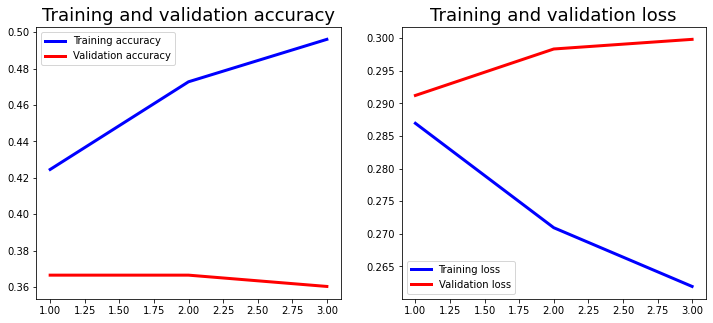

In [ ]:
history = model_glove.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, batch_size=4,
                          shuffle = True, callbacks = callback)

plot_model(history)

In [ ]:
model_glove.save('/content/drive/My Drive/My Works/Bangla YouTube/model_stacked_lstm_pretrained_bangla.h5')

In [ ]:
model_glove.evaluate(test_data, test_label, verbose = 1)

7/7 [==============================] - 0s 8ms/step - loss: 0.2778 - accuracy: 0.4505 - f1_m: 0.3723 - precision_m: 0.5691 - recall_m: 0.2795


[0.27776092290878296,
 0.45049506425857544,
 0.37232866883277893,
 0.5690888166427612,
 0.2794642746448517]

## 5. Testing the all the above models with a random text

In [ ]:
test_text = 'খুব ভালো লাগল'
test_text = pd.Series(test_text)

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen = input_length)

In [ ]:
label_encoder.classes_[np.argmax(model.predict(data))]

'joy'

In [ ]:
label_encoder.classes_[np.argmax(model_lstm.predict(data))]

'joy'

In [ ]:
label_encoder.classes_[np.argmax(model_glove.predict(data))]

'joy'

In [ ]:
print(label_encoder.classes_)

['anger' 'disgust' 'fear' 'joy' 'none' 'others' 'sad' 'surprise']


In [ ]:
np.around(model.predict(data), decimals = 2)

array([[0.  , 0.  , 0.  , 0.93, 0.03, 0.  , 0.  , 0.02]], dtype=float32)

In [ ]:
np.around(model_glove.predict(data), decimals = 2)

array([[0.05, 0.12, 0.  , 0.44, 0.29, 0.  , 0.04, 0.06]], dtype=float32)

In [ ]:
np.around(model_lstm.predict(data), decimals = 2)

array([[0.03, 0.1 , 0.  , 0.45, 0.21, 0.01, 0.06, 0.13]], dtype=float32)